tensor(-6)


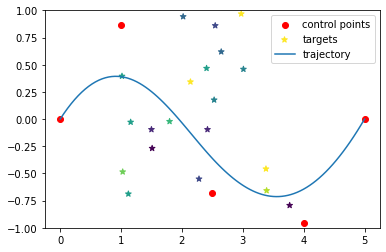

In [1]:
import torch
import matplotlib.pyplot as plt
from src import splev, evaluate,generate_game,compute_traj

P = 3
N_CTPS = 5
N_TARGETS = 20
N_CLASSES = 10
RADIUS = 0.3

# To understand what a trajectory looks like,
# let's generate a B-Spline of degree P with N control points from (0,0) to (N_CTPS,0).
# Note that a (clamped) B-Spline passes through its first and last control points.

t = torch.linspace(0, N_CTPS-P, 100)
knots = torch.cat([
    torch.zeros(P), 
    torch.arange(N_CTPS+1-P), 
    torch.full((P,), N_CTPS-P),
])
ctps = torch.zeros(N_CTPS, 2)
ctps[0] = torch.tensor([0., 0.])
ctps[1:-1, 0] = torch.linspace(1, N_CTPS-1, N_CTPS-2)
ctps[1:-1, 1].uniform_(-1, 1)
ctps[-1] = torch.tensor([N_CTPS, 0.])
traj = splev(t, knots, ctps, P)

# Generate N_TARGETS targets
# essentially the same as `generate_game` function provided
class_scores = torch.randint(-N_CLASSES, N_CLASSES, (N_CLASSES,))
target_pos = torch.rand((N_TARGETS, 2)) * torch.tensor([N_CTPS-2, 2.]) + torch.tensor([1., -1.])
target_cls = torch.randint(0, N_CLASSES, (N_TARGETS,))
target_scores = class_scores[target_cls]

plt.scatter(*ctps.T, color="red", label="control points")
plt.scatter(*target_pos.T, c=target_cls, marker="*", label="targets")
plt.plot(*traj.T, label="trajectory")
plt.ylim(-1, 1)
plt.legend()

# evaluate the trajectory by checking which targets does it hit
# your goal is to choose ctps[1:-1] so that the score is maximized
score = evaluate(traj, target_pos, target_scores, RADIUS)
print(score)

tensor(53)


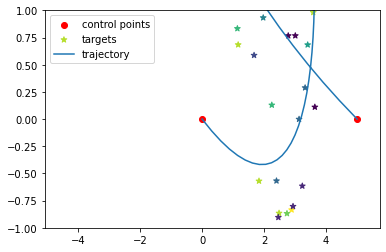

In [4]:
from agent import Agent


data = torch.load("data.pth")
label = data["label"]
feature = data["feature"]
    
target_pos, target_features, target_cls, class_scores = generate_game(N_TARGETS, N_CTPS, feature, label)
target_scores = class_scores[target_cls]
# Agent makes action
agent = Agent()
ctps_inter = agent.get_action(target_pos, target_features, class_scores)
traj = compute_traj(ctps_inter)
ctps = torch.zeros(N_CTPS, 2)
ctps[0] = torch.tensor([0., 0.])
ctps[-1] = torch.tensor([N_CTPS, 0.])
ctps[1:-1] = ctps_inter
# Score
score = evaluate(traj, target_pos, target_scores, RADIUS)
print(score)

plt.scatter(*ctps.T, color="red", label="control points")
plt.scatter(*target_pos.T, c=target_cls, marker="*", label="targets")
plt.plot(*traj.T, label="trajectory")
plt.ylim(-1, 1)
plt.legend()
